In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [36]:
# read whole year data
allFiles = glob.glob("data/*/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,encoding="utf-8")
    list_.append(df)
df = pd.concat(list_)

In [37]:
df.drop_duplicates(inplace=True)

In [38]:
def transform_cols(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace('_', ' ')
    return df

In [39]:
df = transform_cols(df)

In [40]:
df.groupby(['rejected reason']).size() \
    .reset_index(name="counts") \
    .sort_values(['counts'], ascending=False)

,rejected reason,counts
5,No start - Cannot contact,88546
13,No start - Not serious/Researching,48183
23,No start - Withdrawn from market,17962
24,No start - Wrong Number,13432
9,No start - Insufficient income,10908
8,No start - Insufficient deposit or savings,9696
2,No start - Can't dislodge lender,8762
10,No start - No lender match,6379
18,No start - Refinance NOT cost effective,3437
3,No start - Can't dislodge other broker,3210


In [41]:
selected_features = ['classification','enquired',
                     'loan amount','loan reason','property use']
# selected_features = ['marketing code','enquired',
#                      'loan amount','loan reason','property use']
# selected_features = ['classification','enquired']
target = 'enquiry status';
whole_set = selected_features + [target]

df = df[whole_set]

In [42]:
df = df[~df[target].isin(['In Progress','Just Received','On Hold'])]
df.shape

(269530, 6)

In [43]:
def clearnLoanAmount(df): 
    invalid_columns= ['500001-$1000000',
                  '300001-$500000',
                  '0-$300000',
                  '250000 - 300000',
                  '250000-350000',
                  '2600 monthly',
                  'not_sure',
                  '1000,001+',
                 '9999-',
                  'I50000',
                  '1.5 M',
                  '1000001+',
                  '9999-',
                  '80-90k']
    if 'loan amount' in df.columns: 
        df['loan amount'].fillna(0,inplace=True)
        # convert to string to do replacement
        df['loan amount'] = df['loan amount'].astype("str")
        df['loan amount'] = df['loan amount'].str.replace(",","")
        df = df[~df['loan amount'].isin(invalid_columns)]
    return df

In [44]:
df = clearnLoanAmount(df)

In [11]:
df.shape

(268768, 6)

In [46]:
df['loan reason'].value_counts()

First HomeBuyer                                           116638
Buying Again                                               84404
Refinance                                                  25552
Buying Again,Refinance                                     10072
Refinance With Cash Out                                     6837
Buying Again,Refinance With Cash Out                         721
Refinance,Refinance With Cash Out                            646
First HomeBuyer,Refinance                                    385
First HomeBuyer,Buying Again                                 278
Loan Topup                                                   230
Other Loan Reason                                            115
Buying Again,Refinance,Refinance With Cash Out                59
First HomeBuyer,Refinance With Cash Out                       32
Refinance,Loan Topup                                          29
Refinance,Other Loan Reason                                   23
Buying Again,Other Loan R

In [47]:
df['property use'].value_counts()

Residence                     175139
Investment                     26698
Residence,Investment           10253
Other                           2660
Residence,Other                  214
Investment,Other                  45
Residence,Investment,Other        33
Name: property use, dtype: int64

In [13]:
for _ in df.columns:
    print("The number of null values in: {} == {}".format(_, df[_].isnull().sum()))

The number of null values in: classification == 358
The number of null values in: enquired == 0
The number of null values in: loan amount == 0
The number of null values in: loan reason == 22671
The number of null values in: property use == 53726
The number of null values in: enquiry status == 0


In [14]:
df.dropna(axis=0, how='any', inplace=True)
# df = df[~df['marketing code'].isnull()]
# df = df[~df['post code'].isnull()]
# df = df[~df['suburb'].isnull()]
# df = df[~df['loan reason'].isnull()]
# df = df[~df['property use'].isnull()]
df.shape

(214667, 6)

In [15]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:classification == 0
The number of null values in:enquired == 0
The number of null values in:loan amount == 0
The number of null values in:loan reason == 0
The number of null values in:property use == 0
The number of null values in:enquiry status == 0


In [16]:
drop_values = ['QLD','victoria',"270-1176","VIC","2575b","6110r","2150s"]
if 'post code' in df.columns: 
    df = df[~df['post code'].isin(drop_values)]

In [17]:
def transform(df): 
    if 'loan amount' in df.columns: 
        df['loan amount'] = df['loan amount'].astype('float')
        
    if 'enquired' in df.columns: 
        df['enquired'] = pd.DatetimeIndex(df['enquired'])
        df['year'] = df['enquired'].dt.year
        df['month'] = df['enquired'].dt.month
        df['day'] = df['enquired'].dt.day
        df['hour'] = df['enquired'].dt.hour
        df['weekday'] = df['enquired'].dt.dayofweek
    
    if 'post code' in df.columns: 
        df['post code'] = df['post code'].astype('int')
    
    if 'enquired'in df.columns:
        df.drop(['enquired'], axis = 1, inplace = True)
        
    
    df.apply(lambda x: x.astype(str).str.lower())

In [18]:
transform(df)

In [19]:
if 'year' in df.columns:
    df = df[~(df['year'] < 2009)]
    df[(df['year'] < 2009)]

In [20]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:classification == 0
The number of null values in:loan amount == 0
The number of null values in:loan reason == 0
The number of null values in:property use == 0
The number of null values in:enquiry status == 0
The number of null values in:year == 0
The number of null values in:month == 0
The number of null values in:day == 0
The number of null values in:hour == 0
The number of null values in:weekday == 0


In [21]:
df.reset_index(drop=True,inplace=True)

In [22]:
test = df[df['enquiry status'] == 'Rejected']
test.shape

(166022, 10)

In [23]:
test = df[df['enquiry status'] == 'Accepted']
test.shape

(48526, 10)

In [24]:
# df.to_csv("2011-2017.csv",index=False)
df.describe()

,loan amount,year,month,day,hour,weekday
count,2.145480e+05,214548.000000,214548.000000,214548.000000,214548.000000,214548.000000
mean,3.563434e+05,2013.947252,6.353925,16.058057,14.381225,2.787003
std,3.912571e+05,2.166315,3.302129,9.051795,5.292336,1.988438
min,0.000000e+00,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,1.900000e+05,2013.000000,4.000000,8.000000,11.000000,1.000000
50%,3.200000e+05,2014.000000,6.000000,16.000000,15.000000,3.000000
75%,4.500000e+05,2016.000000,9.000000,24.000000,19.000000,4.000000
max,1.000000e+07,2017.000000,12.000000,31.000000,23.000000,6.000000


In [25]:
test['year'].value_counts()

2015    7594
2014    6819
2013    6324
2016    6151
2010    6045
2011    5891
2012    4858
2017    4446
2009     398
Name: year, dtype: int64

In [26]:
df.dtypes

classification     object
loan amount       float64
loan reason        object
property use       object
enquiry status     object
year                int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [27]:
df['classification'].value_counts()

Domain                         43106
Google AdWords                 25592
Direct                         24073
REA                            19487
Alternative Media              15666
Affiliate                      11641
None                           10010
Coregistration                  8803
Home Sales                      7916
All Homes                       7617
Domain Campaigns                5105
Omnilead                        4694
Partners                        4689
Phone                           4332
Email eChoice Database          3703
Domain Internal CBA Program     3407
Finder                          2925
Domain Campaigns CPA            1973
Folio                           1077
Refinancing AdWords              884
Retention                        817
External Email                   813
First Home Buyers                808
Portals                          701
Manila                           604
Portal Campaigns                 562
Referrer                         555
S

In [28]:
# rows_to_drop = df[df['marketing code'].isin(list_to_drop)]
# rows_to_drop[rows_to_drop['enquiry status'] == 'Rejected'].count()

In [29]:
# df = df[~df['marketing code'].isin(rows_to_drop)]
# df.shape
df.drop_duplicates(inplace=True)

In [30]:
hist = test.groupby(['year']).size().reset_index(name="counts")

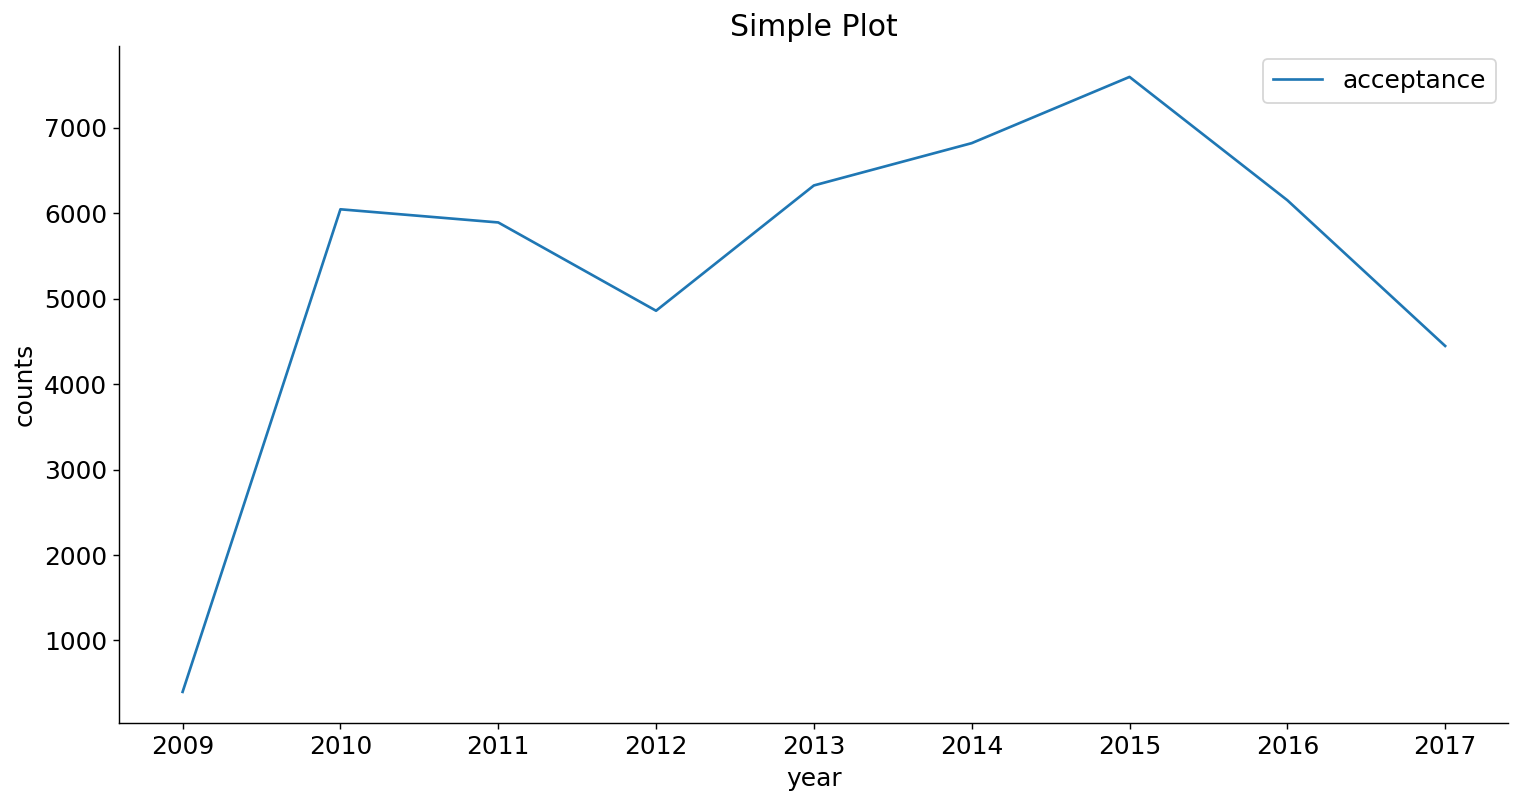

In [31]:
fig = plt.figure()
plt.plot(hist["year"], hist["counts"], label='acceptance')
plt.xlabel('year')
plt.ylabel('counts')
plt.title("Simple Plot")
plt.legend()
plt.show()

In [32]:
data_frame = df.drop('year', axis = 1) 
data_frame.to_csv("2009-2017.csv",index=False)

In [33]:
# df.to_csv("2014-2017.csv",index=False)

In [34]:
data_frame.corr()

,loan amount,month,day,hour,weekday
loan amount,1.000000,0.002422,-0.000182,0.002808,0.009933
month,0.002422,1.000000,0.003408,-0.017000,-0.001564
day,-0.000182,0.003408,1.000000,-0.002158,0.014645
hour,0.002808,-0.017000,-0.002158,1.000000,-0.015292
weekday,0.009933,-0.001564,0.014645,-0.015292,1.000000


Because marketing code is variable that has changed in so many years, so it has much less impact on the result compare to other features